# Exploration of results from Bayesian modelling

In [1]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from tqdm import tqdm

In [2]:
INPUT_FILE = 'n209d1000t500.pickle'

In [3]:
res = pd.read_pickle(INPUT_FILE)
model = res['model']
trace = res['trace']

Could not import matplotlib.animation 'ascii' codec can't decode byte 0xc2 in position 90: ordinal not in range(128)


In [4]:
gal_pa_samples = pd.DataFrame(
    trace['normal_model_phi_gal'].T,
    index=model.galaxies.index
)

In [5]:
pa_expectation = gal_pa_samples.mean(axis=1)
pa_std = gal_pa_samples.std(axis=1)

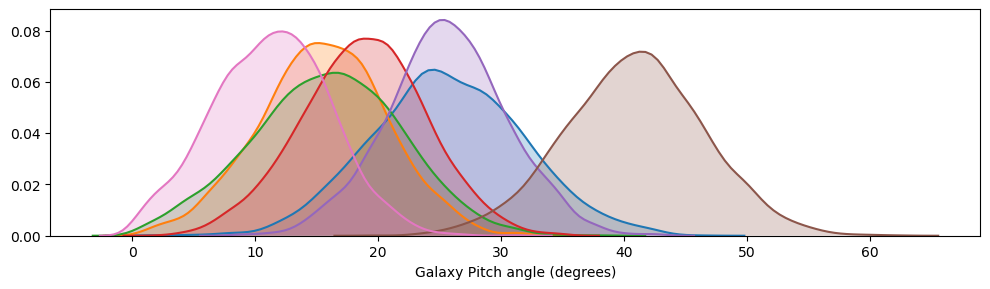

In [6]:
plt.figure(figsize=(12, 3), dpi=100)
sample = pa_expectation.sample(5)
for i, idx in enumerate(sample.index.values.tolist() + [pa_expectation.idxmax(), pa_expectation.idxmin()]):
    sns.kdeplot((gal_pa_samples.loc[idx]), shade=True, color=f'C{i}')
# i = (gal_pa_samples.idxmax(), gal_pa_samples.idxmin())
plt.xlabel('Galaxy Pitch angle (degrees)')
plt.gca().get_legend().remove()
plt.savefig('plots/gal_pa_kde_sample.png', bbox_inches='tight')

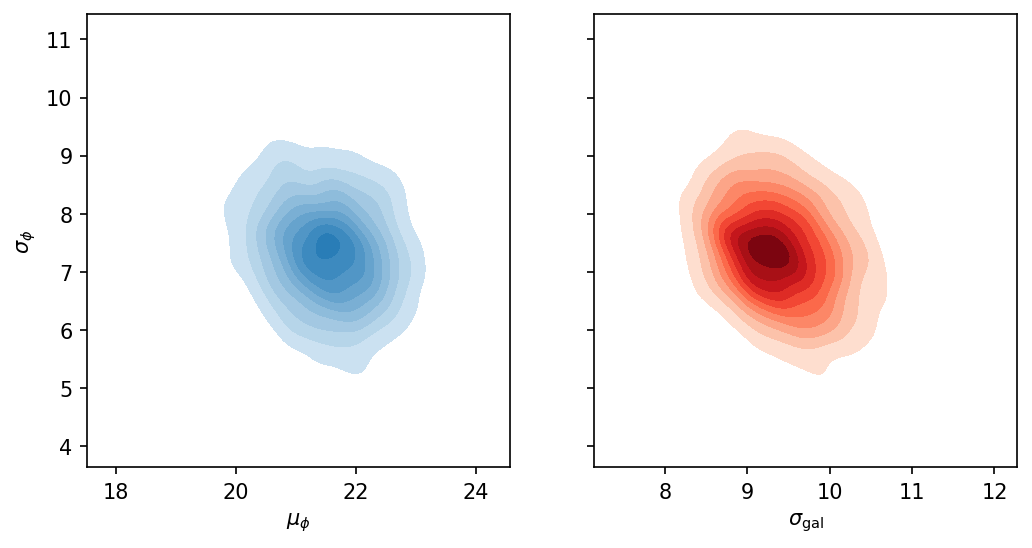

In [7]:
f, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 4), dpi=150)
plt.sca(ax[0])
sns.kdeplot(trace['normal_model_mu_phi'], trace['normal_model_sigma_phi'], shade=True, shade_lowest=False)
plt.xlabel(r'$\mu_\phi$')
plt.ylabel(r'$\sigma_\phi$')
plt.sca(ax[1])
sns.kdeplot(trace['normal_model_sigma_gal'], trace['normal_model_sigma_phi'], shade=True, shade_lowest=False, cmap='Reds')
plt.xlabel(r'$\sigma_\mathrm{gal}$')
plt.savefig('plots/global_mu_sigma_constraints.png', bbox_inches='tight')

Let's get some values for the length-weighted pitch angle of our galaxies:

In [8]:
# sample extraction
galaxies_df = pd.read_pickle('lib/spiral_arms.pickle')
# keep only galaxies with one arm or more
galaxies_df = galaxies_df[galaxies_df.notna().any(axis=1)]
pa_lw_mean = galaxies_df.apply(
    lambda row: row['pipeline'].get_pitch_angle(row.dropna().values[1:])[0],
    axis=1
).reindex_like(galaxies_df)

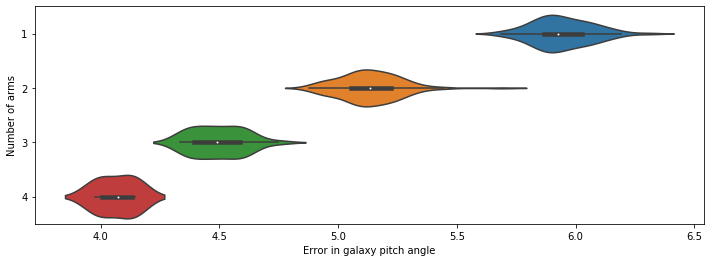

In [9]:
plt.figure(figsize=(12, 4))
sns.violinplot(pa_std, model.galaxies.apply(len), orient='horizontal')
plt.xlabel('Error in galaxy pitch angle')
plt.ylabel('Number of arms')
plt.savefig('plots/error_vs_n_arms.png', bbox_inches='tight')

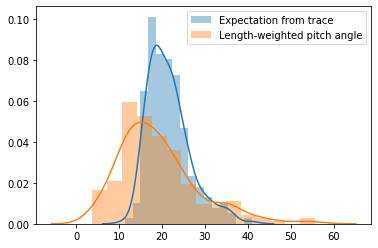

In [10]:
sns.distplot(pa_expectation, label='Expectation from trace')
sns.distplot(pa_lw_mean.dropna(), label='Length-weighted pitch angle')
plt.legend()

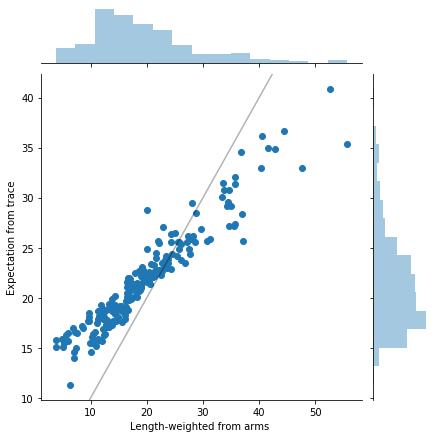

In [11]:
g = sns.jointplot(
    pa_lw_mean.dropna(), pa_expectation
).set_axis_labels('Length-weighted from arms ', 'Expectation from trace')
g.ax_joint.add_line(plt.Line2D(*[[0, 90]]*2, color='k', alpha=0.3))

In [12]:
bar_fracs = pd.read_pickle('lib/bar_fractions.pkl')
bulge_fracs = pd.read_pickle('lib/bulge_fractions.pkl')

In [13]:
morphology_comparison = pd.concat((
    bar_fracs.rename(columns={'GZ2 bar fraction': 'bar fraction'}).drop('GZB fraction', axis=1),
    bulge_fracs.rename(columns={'GZ2 no bulge': 'bulge fraction'}).drop('GZB fraction', axis=1),
    pa_expectation.rename('phi'),
    pa_std.rename('sd'),
    model.galaxies.apply(len).rename('n'),
), axis=1).dropna()

In [14]:
n_bulge_dominated = morphology_comparison['GZ2 bulge dominated'].sum()
n_disc_dominated = np.logical_not(morphology_comparison['GZ2 bulge dominated']).sum()
n_bar = morphology_comparison['No bar'].sum()
n_no_bar = np.logical_not(morphology_comparison['No bar']).sum()

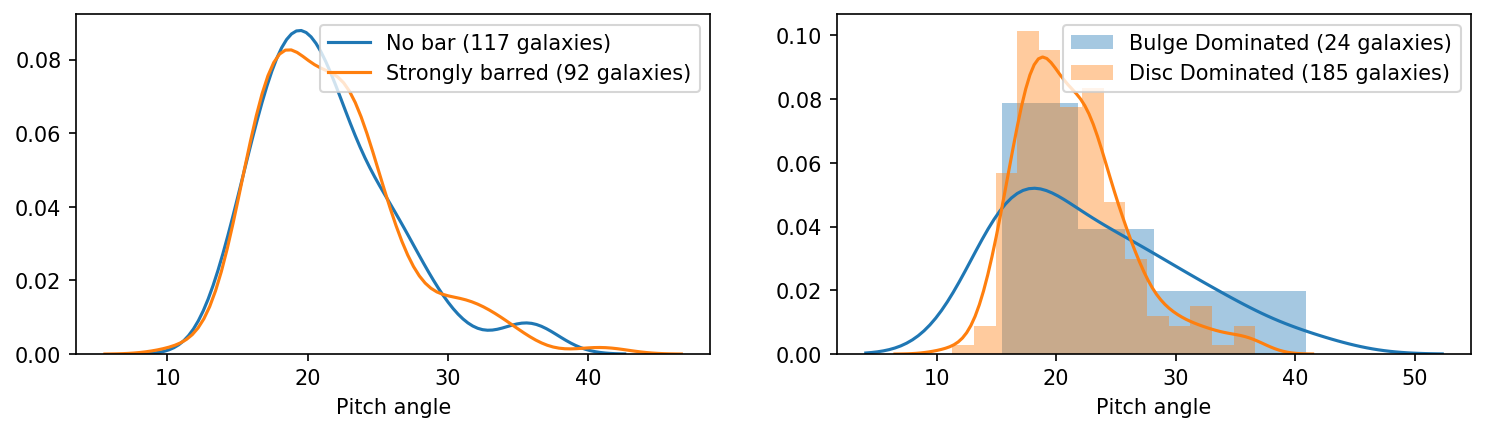

In [15]:
plt.figure(figsize=(12, 3), dpi=150)
plt.subplot(121)
sns.kdeplot(
    morphology_comparison['phi'][morphology_comparison['No bar']].rename('No bar'),
    label=f'No bar ({n_no_bar} galaxies)'
)
sns.kdeplot(
    morphology_comparison['phi'][np.logical_not(morphology_comparison['No bar'])].rename('Bar'),
    label=f'Strongly barred ({n_bar} galaxies)'
)
plt.xlabel('Pitch angle')
plt.subplot(122)
sns.distplot(
    morphology_comparison['phi'][
        morphology_comparison['GZ2 bulge dominated']
    ],
    label=f'Bulge Dominated ({n_bulge_dominated} galaxies)'
)
sns.distplot(
    morphology_comparison['phi'][
        np.logical_not(morphology_comparison['GZ2 bulge dominated'])
    ],
    label=f'Disc Dominated ({n_disc_dominated} galaxies)'
)
plt.xlabel('Pitch angle')
plt.legend()

In [16]:
def set_color_by_correlation(row, cmap=cm.get_cmap('RdYlGn', 12)):
    values = (np.array([cmap((value + 1) / 2) for value in row])  * [256, 256, 256, 1]).astype(int)
    return [f'background-color: rgba{tuple(value.tolist())}' for value in values]

corr_df = morphology_comparison.drop(columns=['No bar', 'Strongly barred', 'GZ2 bulge dominated']).corr(method='kendall')
corr_df.style.apply(set_color_by_correlation)

,bar fraction,bulge fraction,phi,sd,n
bar fraction,1,0.0714424,-0.00382568,-0.135374,0.166472
bulge fraction,0.0714424,1,0.0114804,-0.0287477,0.0424388
phi,-0.00382568,0.0114804,1,-0.181082,0.128063
sd,-0.135374,-0.0287477,-0.181082,1,-0.775143
n,0.166472,0.0424388,0.128063,-0.775143,1


In [17]:
morphology_comparison['bar fraction']

20901990    0.263000
20901992    0.234521
20901993    0.778075
20901995    0.239344
20901996    0.186207
              ...   
21686607    0.016589
21686609    0.076164
21686610    0.088381
21686612    0.784840
21686615    0.450600
Name: bar fraction, Length: 209, dtype: float64

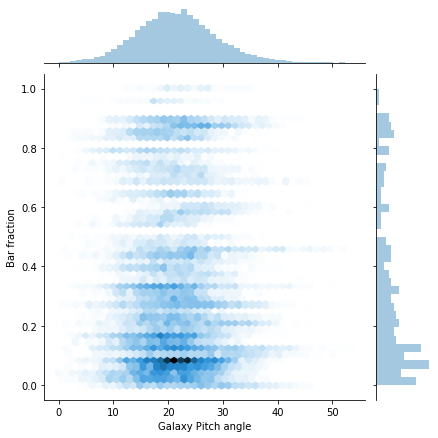

In [18]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bar fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex')
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bar fraction')
del foo

In [19]:
model.model.name

'normal_model'

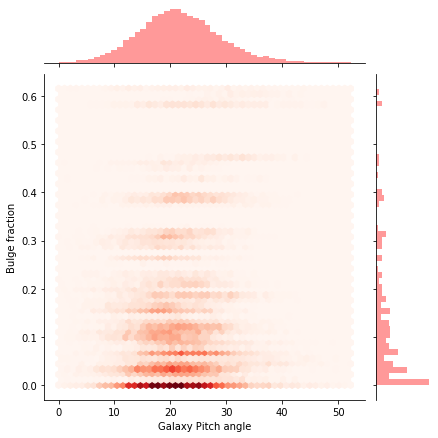

In [20]:
foo = gal_pa_samples.T.sample(100).T
foo = pd.concat((foo, morphology_comparison['bulge fraction']), axis=1).values
g = sns.jointplot(foo[:, :-1].ravel(), np.repeat(foo[:, -1], len(foo[0]) - 1), kind='hex', cmap='Reds', marginal_kws=dict(color='red'))
g.ax_joint.set_xlabel('Galaxy Pitch angle')
g.ax_joint.set_ylabel('Bulge fraction')
del foo

Text(0, 0.5, 'Fraction')

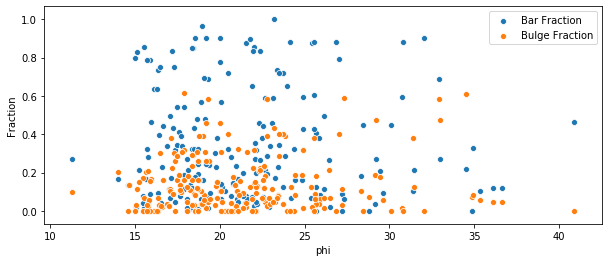

In [21]:
plt.figure(figsize=(10, 4))
sns.scatterplot(x='phi', y='bar fraction', data=morphology_comparison.dropna(), label='Bar Fraction')
sns.scatterplot(x='phi', y='bulge fraction', data=morphology_comparison.dropna(), label='Bulge Fraction')
plt.ylabel('Fraction')

In [22]:
gz2_spiral_data = pd.read_csv('lib/gz2_spiral_data.csv', index_col=0)

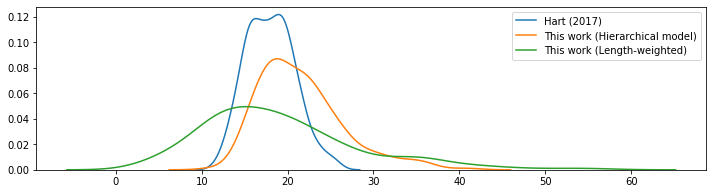

In [23]:
plt.figure(figsize=(12, 3))
sns.kdeplot(gz2_spiral_data['hart_pa'].dropna(), label='Hart (2017)')
sns.kdeplot(pa_expectation, label='This work (Hierarchical model)')
sns.kdeplot(pa_lw_mean.dropna(), label='This work (Length-weighted)')

,GZ2 Winding coefficient,Hart (2017),Expectation,Length-weighted
GZ2 Winding coefficient,1,0.957395,0.450358,0.437633
Hart (2017),0.957395,1,0.404686,0.385381
Expectation,0.450358,0.404686,1,0.955291
Length-weighted,0.437633,0.385381,0.955291,1


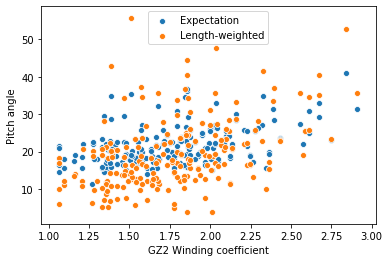

In [24]:
sns.scatterplot(gz2_spiral_data['winding'], pa_expectation, label='Expectation')
sns.scatterplot(gz2_spiral_data['winding'], pa_lw_mean, label='Length-weighted')
plt.xlabel('GZ2 Winding coefficient')
plt.ylabel('Pitch angle')
pd.concat((
    gz2_spiral_data['winding'].rename('GZ2 Winding coefficient'),
    gz2_spiral_data['hart_pa'].rename('Hart (2017)'),
    pa_expectation.rename('Expectation'),
    pa_lw_mean.rename('Length-weighted'),
), axis=1).corr().style.apply(set_color_by_correlation)

Text(0, 0.5, 'This work')

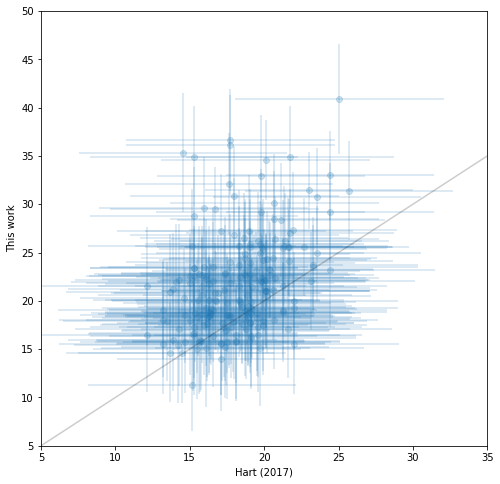

In [25]:
plt.figure(figsize=(8, 8))
df = pd.concat((gz2_spiral_data['hart_pa'], pa_expectation.rename('pa'), pa_std.rename('err')), axis=1).dropna()
plt.errorbar(df['hart_pa'], df['pa'], xerr=7, yerr=df['err'], fmt='o', alpha=0.2)
l = np.stack((plt.ylim(), plt.xlim()))
plt.plot((0, 90), (0, 90), c='k', alpha=0.2)
plt.xlim(5, 35)
plt.ylim(5, 50)
plt.xlabel('Hart (2017)')
plt.ylabel('This work')

# Comparison to Cot uniform model

In [26]:
cot_res = pd.read_pickle('cot_uniform_comparison.pickle')

In [27]:
cot_res['normal_trace']['normal_model_phi_gal'].mean(axis=0).shape

(136,)

In [28]:
import scipy.stats as st
def cot(phi):
    return 1 / np.tan(np.radians(phi))
def acot(a):
    return np.degrees(np.arctan(1 / a))
hist, bin_edges = np.histogram(
    acot(st.uniform(1, 4).rvs(100000)),
    bins='scott', density=True
)

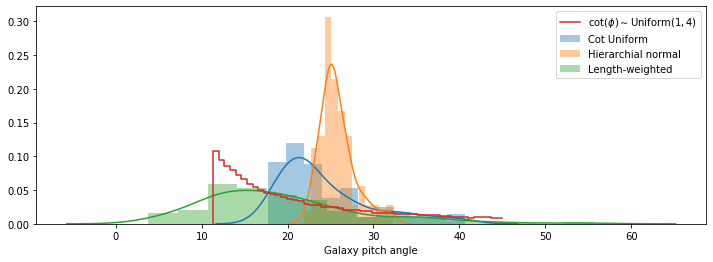

In [29]:
plt.figure(figsize=(12, 4))
sns.distplot(cot_res['cot_trace']['cot_normal_model_phi_gal'].mean(axis=0), label='Cot Uniform')
sns.distplot(cot_res['normal_trace']['normal_model_phi_gal'].mean(axis=0), label='Hierarchial normal')
sns.distplot(pa_lw_mean.dropna(), label='Length-weighted')
plt.step(bin_edges.tolist(), [0] + hist.tolist(), label=r'$\cot(\phi) \sim \mathrm{Uniform}(1, 4)$')
plt.xlabel('Galaxy pitch angle')
plt.legend()

In [31]:
n_gals = cot_res['cot_trace']['cot_normal_model_phi_gal'].shape[1]

In [103]:
# def truncated_normal(mu, sigma):
#     return st.truncnorm(
#         (acot(4) - mu) / sigma,  # lower bound
#         (acot(1) - mu) / sigma,  # upper bound
#         loc=mu,  # mean
#         scale=sigma,  # std
#     )
# starting_mu = trace['normal_model_mu_phi'].mean()
# starting_sd = trace['normal_model_sigma_phi'].mean()
# # ks_res2 = pd.Series([], name='ks_test_result')
# anderson_res = pd.Series([], name='ks_test_result')

# with tqdm(range(100)) as bar:
#     for i in bar:
#         idx = np.random.randint(len(cot_res['cot_trace']), size=n_gals)
#         dataset = np.fromiter((a[i] for i, a in zip(idx, cot_res['cot_trace']['cot_normal_model_phi_gal'].T)), dtype=float)

#         def f(p):
#             return st.kstest(dataset, truncated_normal(*p).cdf).statistic

#         mu_phi, sigma_phi = minimize(f, (starting_mu, starting_sd))['x']
#         anderson_res[i] = st.anderson_ksamp([dataset, truncated_normal(mu_phi, sigma_phi).rvs(100000)])
# #         ks_res2[i] = st.kstest(
# #             dataset,
# #             truncated_normal(mu_phi, sigma_phi).cdf
# #         )
# #     ks_res2 = ks_res2.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})

In [32]:
ks_res = pd.Series([], name='ks_test_result')
for i in range(1000):
    idx = np.random.randint(len(cot_res['cot_trace']), size=n_gals)
    foo = np.fromiter((a[i] for i, a in zip(idx, cot_res['cot_trace']['cot_normal_model_phi_gal'].T)), dtype=float)
    ks_res[i] = st.kstest(
        cot(foo),
        st.uniform(cot(foo).min(), cot(foo).max()).cdf,
    )
ks_res = ks_res.apply(pd.Series).rename(columns={0: 'value', 1: 'p'})

Text(0.5, 0, 'Probability of phi being uniform in cot')

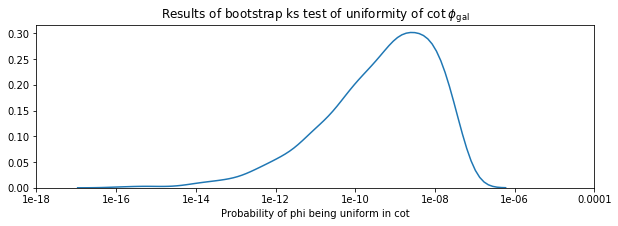

In [53]:
plt.figure(figsize=(10, 3))
sns.kdeplot(np.log10(ks_res['p']), label='')
plt.title(r'Results of bootstrap ks test of uniformity of $\cot\;\phi_\mathrm{gal}$')
plt.xticks(plt.xticks()[0], 10**plt.xticks()[0])
plt.xlabel(r'Probability of phi being uniform in cot')
ks_res.describe()

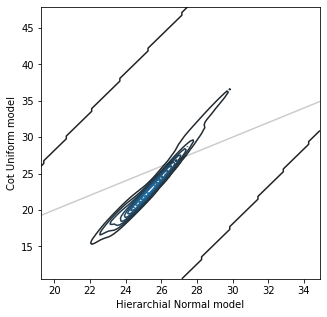

In [38]:
plt.figure(figsize=(5, 5))
sns.kdeplot(
    cot_res['normal_trace']['normal_model_phi_gal'].mean(axis=0),
    cot_res['cot_trace']['cot_normal_model_phi_gal'].mean(axis=0)
)
plt.xlabel('Hierarchial Normal model')
plt.ylabel('Cot Uniform model')
plt.gca().add_line(plt.Line2D((0,90),(0,90), color='k', alpha=0.2))